# Importing Packages

In [3]:
# importing some useful packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import cv2
import glob
import os
import math
# showing images in notebook
%matplotlib inline

# Visualization part

In [4]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)

# Read In An Image

This image is of shape (720, 1280, 3)


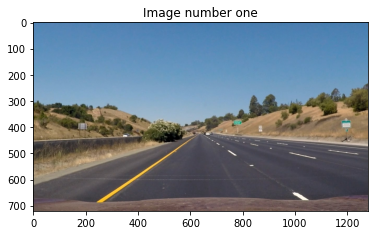

In [5]:
# Reading an image
images_paths = glob.glob("Project_data/test_images/*.jpg")
images = [plt.imread(image) for image in images_paths]

# getting img dimensions and printing it
image_idx = 0

print("This image is of shape {}".format(images[image_idx].shape))
show_image(images[image_idx], "Image number one")

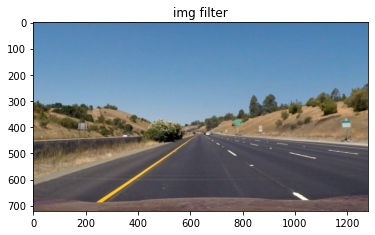

In [20]:
img_filter=gaussian_blur(test_image, 3)
show_image(img_filter, "img filter")

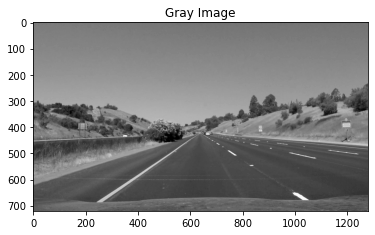

In [21]:
gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

show_image(gray, "Gray Image")

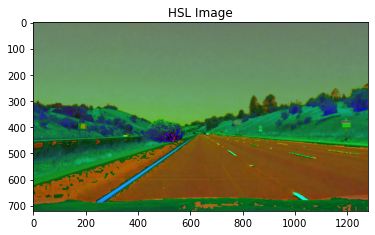

In [22]:
hls_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)

show_image(hls_image, "HSL Image")

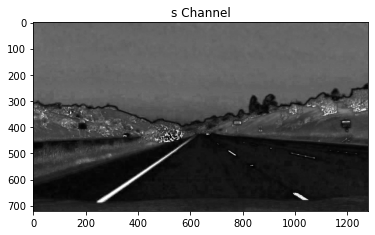

In [23]:
s_channel = hls_image[:, :, 2]
show_image(s_channel, "s Channel")

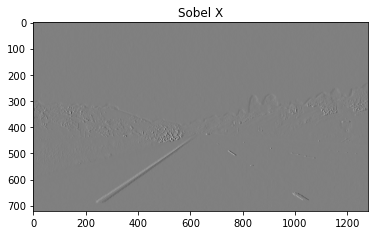

In [25]:
sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)

show_image(sobelx, "Sobel X")

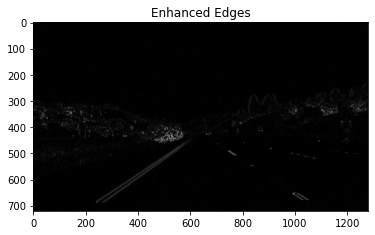

In [26]:
abs_sobel_x = np.absolute(sobelx)
scaled_sobel = 255 * ((abs_sobel_x) / np.max(abs_sobel_x))#scaling
show_image(scaled_sobel, "Enhanced Edges")

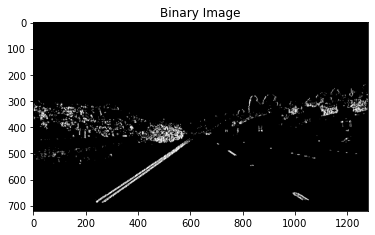

In [27]:
sx_thresh = [20, 200]#threshold

sx_binary = np.zeros_like(scaled_sobel)#the same image=0
sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
show_image(sx_binary, "Binary Image")

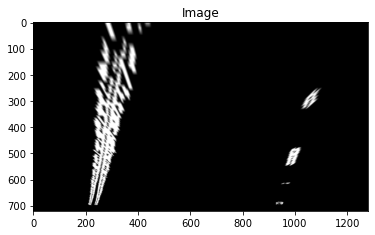

In [30]:
srcPoints = np.array([[200, 700],
                      [580, 450],
                      [670, 450],
                      [1150, 700]]).astype(np.float32)

dstPoints = np.array([[200, 700],
                      [200, 50],
                      [1000, 50],
                      [1000, 700]]).astype(np.float32)

M, Minv = perspectiveTransform(srcPoints, dstPoints)

warped_image = warpPerspective(sx_binary, sx_binary.astype(np.float32).shape[1::-1], M)
show_image(warped_image)


# Helper functions

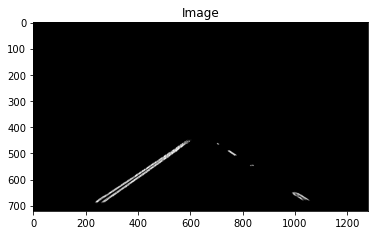

In [31]:
origianl_image = warpPerspective(warped_image, sx_binary.shape[1::-1], Minv)
show_image(origianl_image)

In [6]:
#Grayscale image
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

### Apply gaussian blue to eliminate noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#Brid eye:
### This function returns the prespective and inverse prespective matrix for a prespective transform
def perspectiveTransform(srcPoints, dstPoints):
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)#prespective matrix
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)#inverse prespective matrix
    return M, Minv

### This function applies prespective transform to an image and returns the warped image
def warpPerspective(img, imgSize, M):
    return cv2.warpPerspective(img, M, imgSize, cv2.INTER_LINEAR)

#Get edge detector
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

#HLS image
def HLS(img):
    return cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)

def Lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[3 * binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
             # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



# Helper variables

In [7]:
kernel_size=3
low_threshold=50
high_threshold=150


# Test Images

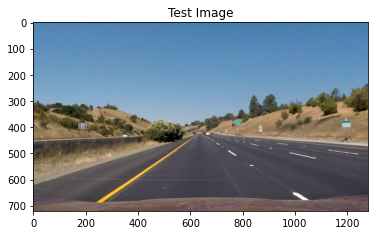

In [8]:
test_image = images[0]

show_image(test_image, "Test Image")

# Start pipeline 

In [15]:
def get_line(img):
    imgSize = img.shape[1::-1]
    img_filter=gaussian_blur(img, 3)  
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:, :, 2]
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobel_x = np.absolute(sobelx)
    scaled_sobel = 255 * ((abs_sobel_x) / np.max(abs_sobel_x))#scaling
    # Threshold x gradient
    sx_thresh=(20, 100)
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    srcPoints = np.float32([(.172 * img.shape[1], img.shape[0]),
                          (.463 * img.shape[1], .626 * img.shape[0]),
                          (.537 * img.shape[1], .626 * img.shape[0]),
                          (.87 * img.shape[1], img.shape[0])])
    
    # destination pts for 1280 x 720 img are (200,720) , (200,0) , (700,0) , (700,720)
    dstPoints = np.float32([(img.shape[1] // 4, img.shape[0]),
                           (img.shape[1] // 4, 0),
                           (3 * img.shape[1] // 4, 0),
                           (3 * img.shape[1] // 4, img.shape[0])])

    M, Minv = perspectiveTransform(srcPoints, dstPoints)

    warped_image = warpPerspective(sx_binary, sx_binary.astype(np.float32).shape[1::-1], M)
    

In [16]:
#imagesList = os.listdir("Project_data/test_images/")

In [19]:
#for i in range(len(imagesList)):
 #   Img = mpimg.imread("Project_data/test_images/"+imagesList[i])
  #  resultImg = get_line(Img)
   # mpimg.imsave("Project_data/output/"+"output_grayscale_"+imagesList[i],resultImg)

In [49]:
#for i in range(len(imagesList)):
 #   Img = mpimg.imread("Project_data/test_images/"+imagesList[i])
  #  resultImg = HLS(Img)
   # h_channel = resultImg[:, :, 0]
   # l_channel = resultImg[:, :, 1]
   # s_channel = resultImg[:, :, 2]
    #mpimg.imsave("Project_data/output/"+"output_s_channel _"+imagesList[i],s_channel )
    